# Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
# iB = 6
m = 0
s = 1
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

iB = 6
mask = mymsk == iB

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# read the files

In [5]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [6]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [7]:
# also calculate surface rho from theta and salt
rho = gsw.rho(salt,theta,0)
rho.shape

(2, 50, 1350, 270)

In [8]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [9]:
# budg2d_zflux_set1: SIatmFW, oceFWflx
file_name = "budg2d_zflux_set1"
SIatmFW = read_field2d(tsstr,ny,nx,file_name,np.array(['SIatmFW']),mymsk,dirIn)
oceFWflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceFWflx']),mymsk,dirIn)

In [10]:
# budg2d_zflux_set2: SIsnPrcp
file_name = "budg2d_zflux_set2"
SIsnPrcp = read_field2d(tsstr,ny,nx,file_name,np.array(['SIsnPrcp']),mymsk,dirIn)

In [11]:
# budg2d_snap_set1: SIarea (for percent ocean/ice covered)
file_name = "budg2d_snap_set1"
SIarea = read_field2d(tsstr,ny,nx,file_name,np.array(['SIarea']),mymsk,dirIn)

# create the TS bins

In [12]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [13]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [14]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

# try to select from BarentsS

In [15]:
np.where(mymsk == 1)

(array([434, 434, 434, ..., 561, 561, 561]),
 array([162, 163, 246, ...,  51,  52,  53]))

In [16]:
iB = 6
print(strb[iB])

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(mymsk == 1)
npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs,dT,dS)
print(mesh.shape)

mydata_test_m1 = np.nansum(mesh[m],axis=2)#/binwidthsS_tile/binwidthsT_tile    # this has already been done in the function!!
mydata_test_m2 = np.nansum(mesh[s],axis=2)#/binwidthsS_tile/binwidthsT_tile

# make a mask for iB so we can multiply the advective terms
mymsk_iB = mskBasin.copy()

# Create a boolean mask for elements iB
mask = (mymsk_iB==6) 

# Set non iB elements to nan
mymsk_iB[mask] = 1
mymsk_iB[~mask] = np.nan
mymsk_iB = np.tile(mymsk_iB,(50,1,1))

BarentsS
(2, 112, 112, 10650)


In [17]:
vol[:,0].shape

(2, 1350, 270)

In [18]:
# maybe just look at the surface volume
idxs = np.where(mymsk == 1)
npoints = len(idxs[0])
mesh_surf = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[:,0].reshape(2,1,ny,nx), binned_theta[:,0].reshape(2,1,ny,nx),vol[:,0].reshape(2,1,ny,nx),idxs,dT,dS)
print(mesh.shape)

mydata_test_m1_surf = np.nansum(mesh_surf[m],axis=2)#/binwidthsS_tile/binwidthsT_tile    # this has already been done in the function!!
mydata_test_m2_surf = np.nansum(mesh_surf[s],axis=2)#/binwidthsS_tile/binwidthsT_tile

(2, 112, 112, 10650)


In [19]:
# create two arrays of shape ny, nx -- one for A to O and one for I to O
# also do for SIatmFW and SIsnPrcp

oceFWflx_AtoO = (1-SIarea) * oceFWflx        # kg/m^2/s
oceFWflx_ItoO = SIarea * oceFWflx

SIatmFW_AtoO = (1-SIarea) * SIatmFW          # kg/m^2/s
SIatmFW_ItoO = SIarea * SIatmFW

SIsnPrcp_AtoO = (1-SIarea) * SIsnPrcp        # kg/m^2/s
SIsnPrcp_ItoO = SIarea * SIsnPrcp

# create the vectors for a surface term (ie oceFWflx)

In [20]:
# I think this needs to add a negative forcing in salt because + freshwater should be freshening
def get_surface_distr(indices,attr,month,RAC,rho,nT,nS,binned_salinity,binned_theta):
    # get the surface values of the attribute
    attr_sel = attr[month] * RAC / rho[month][0] * 1e-6    # (kg/m^2/s) * (m^2) / (kg/m^3) = m^3/s = Sv

    # initialize the mesh
    mesh = np.full((nT,nS),0.0)

    # add at the bins - this part might be wrong
    for i,j in zip(indices[0],indices[1]):
        mesh[int(binned_salinity[month][0,i,j]),int(binned_theta[month][0,i,j])] += attr_sel[i,j]
    
    # normalize by the bin widths in S and T
    fX = mesh / binwidthsS_tile / binwidthsT_tile     # Sv/degC/PSU
    fY = mesh / binwidthsS_tile / binwidthsT_tile     # Sv/degC/PSU

    # do the dividing or normalizing
    integral_fX_dT  = fX * binwidthsT_tile      # Sv/PSU
    integral_fY_dS  = fX * binwidthsS_tile      # Sv/degC
    integral_fX_dT[integral_fX_dT == 0] = np.nan 
    integral_fY_dS[integral_fY_dS == 0] = np.nan 

    return(integral_fX_dT,integral_fY_dS)       # Sv/PSU,Sv/degC

In [21]:
# get indices for BarentsS
indices = np.where(~np.isnan(mymsk_iB[0]))
indices

(array([434, 434, 434, ..., 561, 561, 561]),
 array([162, 163, 246, ...,  51,  52,  53]))

In [41]:
# create the bin widths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T        # equivalent of dS
binwidthsT_tile = np.tile(binwidthT, (112, 1))          # equivalent to dT

# select the values of interest and change units
oceFWflx_AtoOX_dT,oceFWflx_AtoOY_dS = get_surface_distr(indices,oceFWflx_AtoO,s,RAC,rho,nT,nS,binned_salinity,binned_theta)
oceFWflx_ItoOX_dT,oceFWflx_ItoOY_dS = get_surface_distr(indices,oceFWflx_ItoO,s,RAC,rho,nT,nS,binned_salinity,binned_theta)

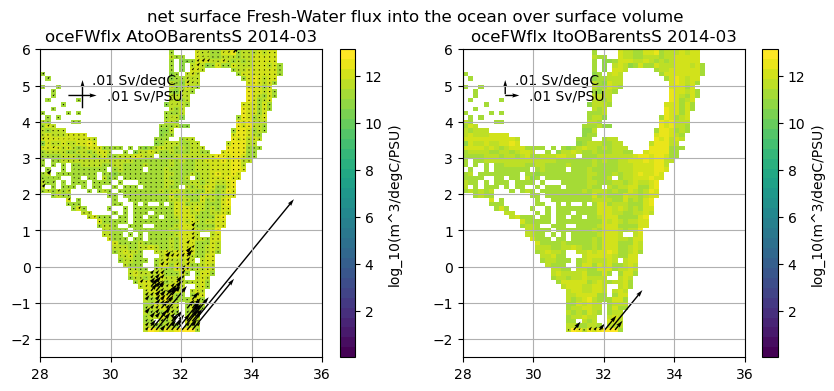

In [49]:
# plot the TS bins
fig = plt.figure()


ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2_surf), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, oceFWflx_AtoOX_dT, oceFWflx_AtoOY_dS,width=0.005,scale=1e-1)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("oceFWflx AtoO" + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

# # Add quiver key for the first subplot
ax1.quiverkey(q1, X=0.2, Y=0.85, U=.01, label='.01 Sv/PSU', labelpos='E')
ax1.quiverkey(q1, X=0.15, Y=0.9, U=.01, label='.01 Sv/degC', labelpos='E',angle = 90)


ax1 = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2_surf), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, oceFWflx_ItoOX_dT, oceFWflx_ItoOY_dS,width=0.005,scale=2e-1)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("oceFWflx ItoO" + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

# # Add quiver key for the first subplot
ax1.quiverkey(q1, X=0.2, Y=0.85, U=.01, label='.01 Sv/PSU', labelpos='E')
ax1.quiverkey(q1, X=0.15, Y=0.9, U=.01, label='.01 Sv/degC', labelpos='E',angle = 90)

plt.suptitle("net surface Fresh-Water flux into the ocean over surface volume")

plt.savefig(path + "sample_oceFWtendencies_Sept.png",dpi=300)

In [34]:
# select the values of interest and change units
SIatmFW_AtoOX_dT,SIatmFW_AtoOY_dS = get_surface_distr(indices,SIatmFW_AtoO,m,RAC,rho,nT,nS,binned_salinity,binned_theta)
SIatmFW_ItoOX_dT,SIatmFW_ItoOY_dS = get_surface_distr(indices,SIatmFW_ItoO,m,RAC,rho,nT,nS,binned_salinity,binned_theta)

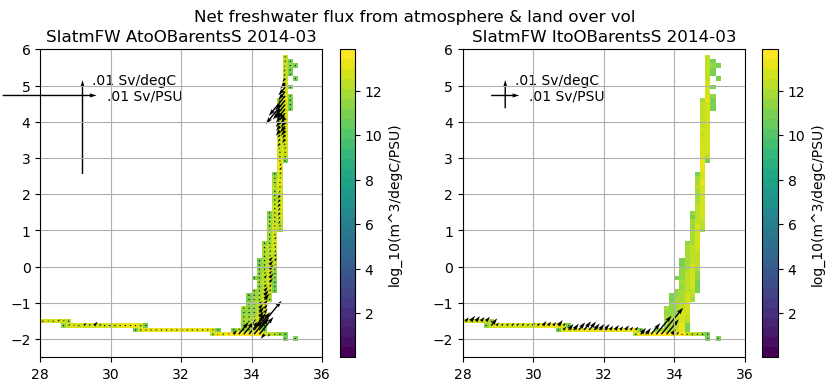

In [35]:
# plot the TS bins
fig = plt.figure()


ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1_surf), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, SIatmFW_AtoOX_dT,SIatmFW_AtoOY_dS ,width=0.005,scale=3e-2)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("SIatmFW AtoO" + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

# # Add quiver key for the first subplot
ax1.quiverkey(q1, X=0.2, Y=0.85, U=.01, label='.01 Sv/PSU', labelpos='E')
ax1.quiverkey(q1, X=0.15, Y=0.9, U=.01, label='.01 Sv/degC', labelpos='E',angle = 90)

ax1 = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1_surf), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent,SIatmFW_ItoOX_dT,SIatmFW_ItoOY_dS ,width=0.005,scale=1e-1)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("SIatmFW ItoO" + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

ax1.quiverkey(q1, X=0.2, Y=0.85, U=.01, label='.01 Sv/PSU', labelpos='E')
ax1.quiverkey(q1, X=0.15, Y=0.9, U=.01, label='.01 Sv/degC', labelpos='E',angle = 90)

plt.suptitle("Net freshwater flux from atmosphere & land over vol")
plt.savefig(path + "sample_SIatmtendencies.png",dpi=300)

# plot in xyz to explain the previous figs

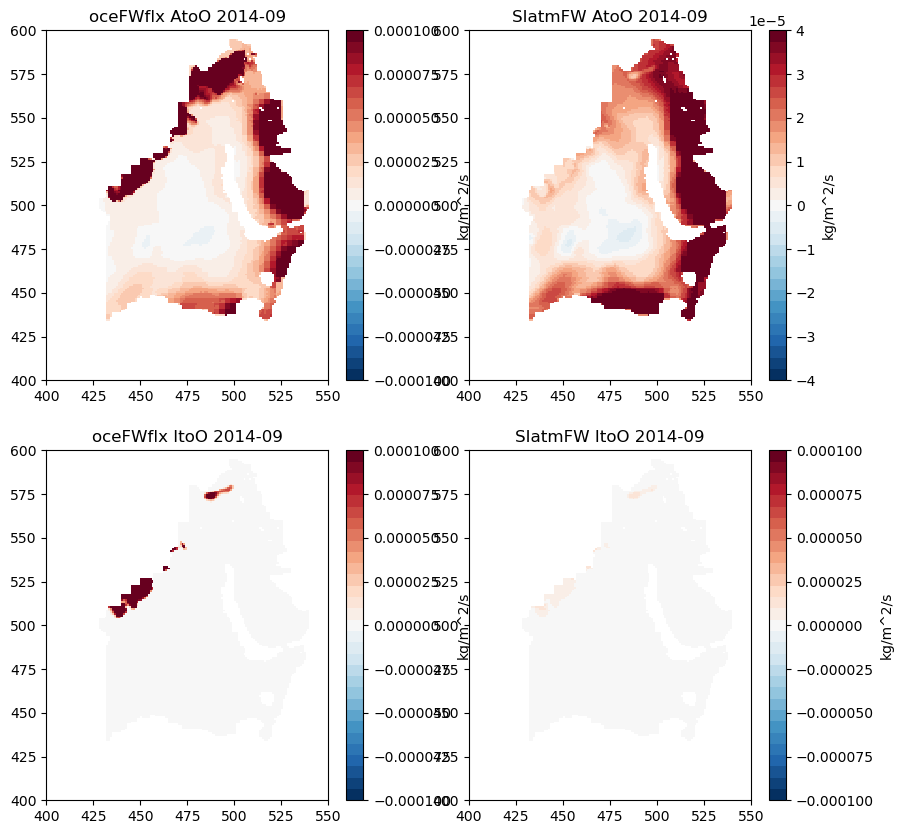

In [44]:
# look at contribution from I to O for the two months and for A to O
fig = plt.figure(figsize=(10,10))


time = s

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_AtoO[time],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx AtoO " + datetimes[time].strftime("%Y-%m"))

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(SIatmFW_AtoO[time],nfx,nfy)[0],cmap=cmap,vmin=-4e-5,vmax=4e-5)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIatmFW AtoO " + datetimes[time].strftime("%Y-%m"))

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_ItoO[time],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx ItoO " + datetimes[time].strftime("%Y-%m"))

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(SIatmFW_ItoO[time],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIatmFW ItoO " + datetimes[time].strftime("%Y-%m"))

plt.savefig(path + "sept_xyzplot_barents_ItoO_AtoO.png",dpi=300)

Text(0.5, 1.0, 'Salt 2014-09')

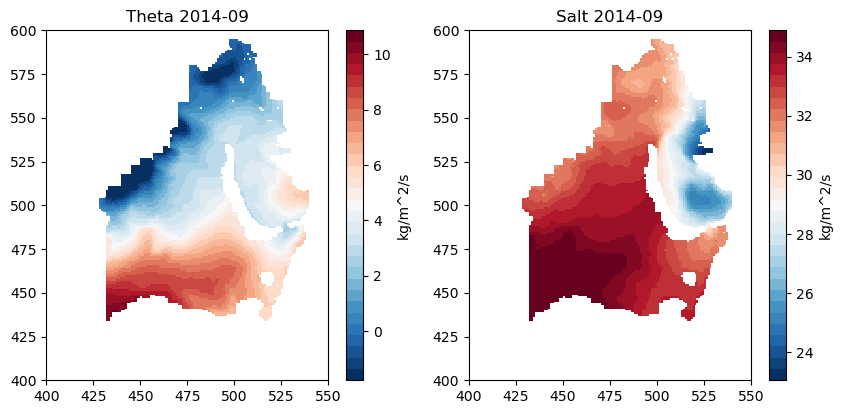

In [47]:
# look at contribution from I to O for the two months and for A to O
fig = plt.figure(figsize=(10,10))


time = s

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(theta[time],nfx,nfy)[0],cmap=cmap)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("Theta " + datetimes[time].strftime("%Y-%m"))

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(salt[time],nfx,nfy)[0],cmap=cmap)
ax.set_xlim(400,550)
ax.set_ylim(400,600)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("Salt " + datetimes[time].strftime("%Y-%m"))